In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4, 2]
from tqdm import tqdm
import numpy as np
from data_processing.neural_networks.RL_Reinforced_Learning.Rl_function_approximation import env_approx
from data_processing.Regression.coarse_coding_bad_approach import tiles
from IPython.display import clear_output
clear_output()
#from misc_tools.print_latex import print_tex

https://github.com/MeepMoop/tilecoding/tree/master

If state space is huge, we want to approximate $v_\pi(s)$ with a function $\hat v(s,\vec{w})$ that can generalize.

$\vec{w} \in \R^d$ is a vector that holds parameters of $\hat v(s,\vec{w})$ and we assume that $ d \ll |S|$. 

Downside of this generalization is that if function generalizes $S_i$ and $S_j$, by updating function value for $\hat v(s = S_i,\vec{w})$ will also affect output for other state

## _Value error_

For individual state $s$ we can write a value error, that shows how good is the approximation:
$$ve(s,\vec{w}) = v_\pi(s)-\hat v(s,\vec{w})$$
We could write an global Value error $\overline{VE}(\vec{w})$, which sums all state value errors (absolute values or powers of 2), but since states are coupled via generalization, we should assign importance for more common states:

$$\overline{VE}(\vec{w}) = \sum_{s \in S} \mu(s)\cdot ve(s,\vec{w})^2 = \sum_{s \in S} \mu(s)\bigg[v_\pi(s)-\hat v(s,\vec{w})\bigg]^2$$

where $\mu(s)$ , for example, is a distribution of time spend on each state $s$


## Stochastic Gradient Descent (SGD)

Gradient of a function $f(\vec{w}):\nabla_{\vec{w}} f(\vec{w})$ shows direction in space of $\vec{w}$ which increases $f(\vec{w})$ the most. 

Conversely, reversed gradient $-\nabla_{\vec{w}} f(\vec{w})$ shows direction of reduction of $f(\vec{w})$

Optimization of $\hat v(s,\vec{w})$, with a goal of better approximation, can be done via gradient descent (GD) by minimizing $\overline{VE}(\vec{w})$.

Particularly this is done by introducing new data into optimization and by it improving current version of weights $\vec{w}_t$ to a better set of weights $\vec{w}_{t+1}$. 

Classic GD updates weights by solving optimization step for all states ${s \in S}$ simultaneously.
$$\vec{w}_{t+1} = \vec{w}_{t} - \alpha \cdot \nabla_{\vec{w}}\big[\overline{VE}(\vec{w}) \big]$$
If we perform this process incrementally for individual state $S_t$ this process is called Stochastic Gradient Descent -  SGD.
$$\vec{w}_{t+1} = \vec{w}_{t} - \alpha \cdot \nabla_{\vec{w}_t} \big[ve(S_t,\vec{w}_t)^2 \big] $$

where $\alpha$ is "step size" or "learning rate". Since we know that value error is quadratic, we can pick a convenient value of $\frac{\alpha}{2}$ for the following chain rule:

$$\vec{w}_{t+1} = \vec{w}_{t} - \frac{1}{2} \alpha\nabla_{\vec{w}_t}\bigg[v_\pi(S_t)-\hat v(S_t,\vec{w}_t)\bigg]^2=$$
$$ = \vec{w}_{t} + \alpha \cdot \bigg[v_\pi(S_t)-\hat v(S_t,\vec{w}_t)\bigg]\cdot \nabla_{\vec{w}_t} \hat v(S_t,\vec{w}_t)$$

Small step/learning rate is necessary since we are observing only a subset of states, which do not represent function globally - fully fixing error on one step/state does not fix other states

We also dont know true value of $v_\pi(s)$, only an estimate. Lets call it $U_t$, so:
$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \hat v(S_t,\vec{w})\bigg]\cdot \nabla_{\vec{w}_t} \hat v(S_t,\vec{w}_t)}$$

Monte Carlo (MC) method estimates true expected discounted reward $U_t = G_t$ and is expected to converge to local optimum:
$$ \vec{w} \leftarrow \vec{w} = \alpha \big[ \underbrace{G_t}_{\text{target}}- \hat v(S,\vec{w}) \big] \cdot \nabla_{\vec{w}_t} \hat v(S,\vec{w})$$

Bootstrapping methods (TD or DP) have target value rewards that are are biased with respect to $\vec{w}_t$:
$$ \text{[TD(0) example]: } \vec{w} \leftarrow \vec{w} = \alpha \big[ \underbrace{R + \gamma \hat v(S^\prime,\vec{w})}_{\text{target}}- \hat v(S,\vec{w}) \big] \cdot \nabla_{\vec{w}_t} \hat v(S,\vec{w})$$
which makes then only 'semi-gradient methods' and they have no convergence guarantees. But in practice they still converge with linear cases. It is important since ability to work online is very beneficial. 

## Linear Methods
$\hat v(\cdot, \vec{w})$ is a linear combination of basis functions $\vec{x}(s) = \{x_1(s), x_2(s),\dots\}^T$
$$\hat v(s, \vec{w}) = \vec{w}^T \vec{x}(s) = \sum_{i = 1}^d w_i x_i(s)$$ 
Gradient is:
$$\nabla_{\vec{w}} \hat v(s, \vec{w}) = \vec{x}(s) $$

so SGD update is

$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \hat v(S_t,\vec{w})\bigg]\cdot \vec{x}(S_t) }$$

For TD(0) method under linear approximation:

$$\vec{w}_{t+1} = \vec{w}_t + \alpha \big[ \underbrace{R_{t+1} + \gamma \hat v(S_{t+1}, \vec{w}_t) }_{\text{target}}- \hat v(S_t,\vec{w}_t) \big] \cdot \vec{x}(S_t) = $$
$$= \vec{w}_t + \alpha \big[R_{t+1} + \gamma \vec{w}_t^T \vec{x}(S_{t+1})  - \vec{w}_t^T \vec{x}(S_t) \big] \cdot \vec{x}(S_t) = $$
$$= \vec{w}_t + \alpha \big[R_{t+1} + \gamma \vec{w}_t^T \vec{x}_{t+1}  - \vec{w}_t^T \vec{x}_t \big] \cdot \vec{x}_t = $$
$$ = 
\vec{w}_t + \alpha \big[R_{t+1}\vec{x}_t -\vec{x}_t(\vec{x}_t- \gamma \vec{x}_{t+1})^T \vec{w}_t $$

When $\vec{w}$ has reached steady state (convergence)
$$\mathbb{E}[\vec{w}_{t+1}|\vec{w}_t] = \vec{w}_t  + \alpha \bigg[ \mathbb{E}[R_{t+1} \vec{x}_t] - \mathbb{E}[\vec{x}_t(\vec{x}_t- \gamma \vec{x}_{t+1})^T]) \bigg] =$$
$$ =  \vec{w}_t + \alpha (\vec{b}- A \vec{w}_t)$$
which converged to $\vec{w}_{TD}$
$$\vec{w}_{TD} = \vec{w}_{TD}   + \alpha (\vec{b}- A \vec{w}_{TD}) \rightarrow$$
$$\vec{0} = \vec{b}- A \vec{w}_{TD}\rightarrow$$
$$ \vec{w}_{TD} = A^{-1}\vec{b}$$
which is a TD _fixed point_. This point is within a certain radius of global minimum. Radius reduces as $\frac{1}{1-\gamma}$

## Polynomials
each state -> k numbers: $\{s_1, s_2,\dots, s_k\}$
for k-dimensional state space, each order $n$ poly can be written as:
$$x_i(s) = \Pi_{k=1}^k s_j^{c_{i,j}}$$
$$c_{i,j} = \{0,1,\dots, n\}$$
i.e
$$k = 2; \ S \rightarrow \{s_1,s_2\}; \ c = 2$$

$$\vec{x} = \{1,s_1,s_2,s_1s_2,s_1^2,s_2^2,s_1s_2^2,s_1^2s_2,s_1^2s_2^2\}$$
$$x_0(s) = 1 = s_1^0s_2^0 \rightarrow c_1 = \{0,0\}$$
$$x_1(s) = s_1 = s_1^1s_2^0 \rightarrow c_2 = \{1,0\}$$
$$\dots$$
$$x_8(s) = s_1^2s_2 = s_1^2s_2^1 \rightarrow c_8 = \{2,1\}$$
$$x_9(s) = s_1^2s_2^2 = s_1^2s_2^1 \rightarrow c_9 = \{2,2\}$$

Cross terms $s_i^a s_j^b$ allows capture state 'interaction'

## Fourier Basis

$$\vec{s} = \{s_1,s_2,\dots, s_k\}^T; s_i \in [0,1]$$
$$x_i(s) = cos(\pi \vec{s}^T \vec{c}^i)$$
$$\vec{c}^i = \{c_1^i,\dots, c_k^i\}^T; \ c_j^i \in \{0,\dots,n\}$$

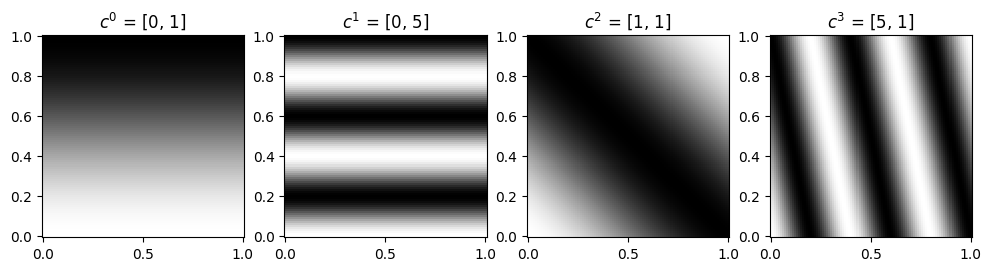

In [21]:
cs = [[0,1],[0,5],[1,1],[5,1]]

def x(s1, s2, c):
    a,b = c
    return np.cos(np.pi * (a* s1 + b* s2))

N = 100
S1,S2 = np.meshgrid(np.linspace(0,1,N),np.linspace(0,1,N))

fig, axs = plt.subplots(1,4, figsize = (12,3))
axs = axs.flatten()

for i,a in enumerate(axs):
    a.pcolormesh(S1,S2,x(S1,S2,cs[i]),cmap='gray')
    a.set_title('$c^'+ str(i)+ '$ = '+ f'{cs[i]}')
    a.set_aspect(1)

***
## Coarse Coding
### Binary features. 

Space is divided in overlapping regions points can be 'present' in multiple neighboring regions, which is one-hot encoded. This allows to keep information about proximity of states (generalization). But it cannot differentiate between states that are too close.

Binary 'basis vectors' are stored as lists of indices, like in https://github.com/MeepMoop/tilecoding/tree/master. Ive also copied mostly optimization code from there (not that its difficult to write lol), and plotting code, which was helpful. Tiling implementation is custom.

*** 
### Example 1D (basis features)

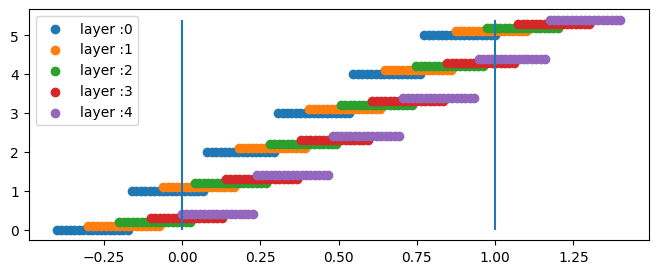

In [19]:
plt.rcParams['figure.figsize'] = [8, 3]
from data_processing.Regression.coarse_coding_tiles_ND import multi_tile
tiles_num = 5;
nt = 4
mt = multi_tile(tiles_num, ['float'], [[0, 1, [nt]*tiles_num, 0.1]])

k = 0
m = 0
for s,t in enumerate(mt.l_maps):
    l_map = t[0]
    mn,mx = l_map.minmax
    x = np.linspace(mn, mx,100)
    y = [l_map(i)+0.1*s for i in x]

    plt.scatter(x,y, label= f'layer :{s}')
    m = max(m,max(y))

plt.vlines([0,1], 0, m);
plt.legend();



$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \hat v(S_t,\vec{w})\bigg]\cdot \vec{x}(S_t) }$$
$$\hat v(s, \vec{w}) = \vec{w}^T \vec{x}(s) = \sum_{i = 1}^d w_i x_i(s)$$ 

### Example 1 - square wave approximation

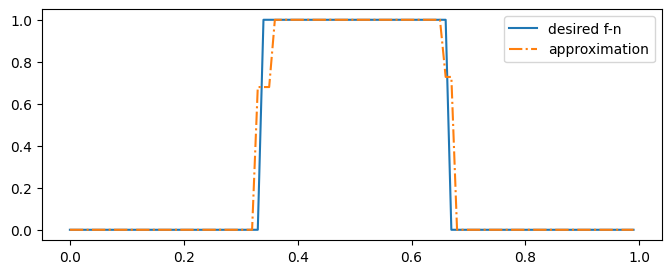

In [27]:
tiles_num = 5;
nt      = 40
mt      = multi_tile(tiles_num, ['float'], [[0, 1, [nt]*tiles_num, 0.1]])

w       = np.zeros(mt.max_tiling_ID)
alpha   = 0.2 / tiles_num

def square_wave(x):
    if x < 1/3 or x > 2/3 : return 0
    else: return 1
    
def model(active_features):
    return np.sum(w[active_features])

for _ in range(10000):
    x               = np.random.random()
    active_features = mt.get_idx((x,))
    sol_model   = model(active_features)
    sol_true    = square_wave(x)
    w[active_features] += alpha * (sol_true - sol_model) 

p_dom = np.arange(0,1,0.01)
plt.plot(p_dom,[square_wave(x)          for x in p_dom] , label = 'desired f-n'  );
plt.plot(p_dom,[model(mt.get_idx((x,))) for x in p_dom] , label = 'approximation', ls='-.');
#plt.plot(start_end[num_segments//2], [0,0]      , label = 'feature width');
plt.legend()
plt.show()

***
### Example 2 - 2D wave approximation
For examples how ive implemented it in [coarse_coding_new.ipynb](../../Regression/coarse_coding_new.ipynb)


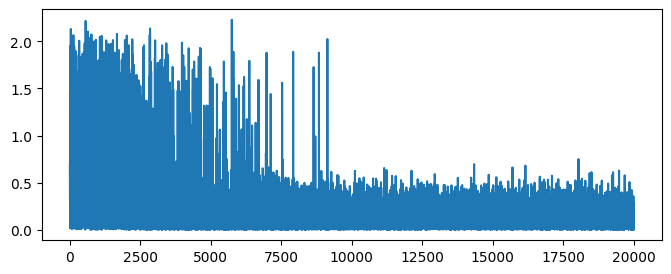

In [28]:
tiles_num = 5;
nt = 40
dt  = 'float'
dt2 = 'float'
dom1 = [0, 2.0 * np.pi, [nt]*tiles_num, 0.1]
dom2 = [0, 2.0 * np.pi, [nt]*tiles_num, 0.1]
dtypes = [dt,dt2]; params = [dom1,dom2]
mt = multi_tile(tiles_num,dtypes,params)

def target_fn(x, y):
  return np.sin(x) + np.cos(y)

def target_fn_noisy(x, y):
  return target_fn(x, y) + 0.1 * np.random.randn()

perf = []
w = np.zeros(mt.max_tiling_ID)
# step size for SGD
alpha = 0.25

# learn from 10,000 samples
for i in range(20000):
   # get noisy sample from target function at random location
  x, y = 2.0 * np.pi * np.random.rand(2)
  target = target_fn_noisy(x, y)
  # get prediction from active tiles at that location
  #active_tiles = get_embed(x,y)
  active_tiles = mt.get_idx((x,y))
  pred = np.sum(w[active_tiles])
  # update weights with SGD
  w[active_tiles] += alpha * (target - pred)
  perf.append(np.abs(target - pred))


plt.plot(perf)

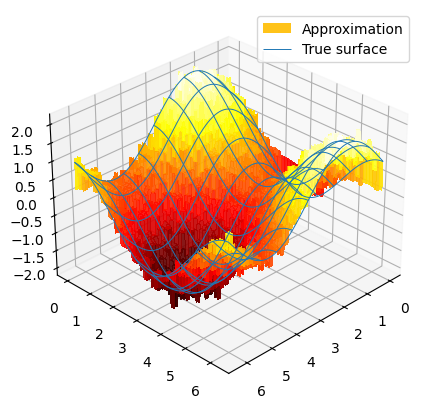

In [29]:
res = 300
x = np.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)
y = np.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)
z = np.zeros([len(x), len(y)])
for i in range(len(x)):
  for j in range(len(y)):
    active_tiles = mt.get_idx((x[i],y[j]))
    z[j,i] = np.sum(w[active_tiles])
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d',computed_zorder=False)
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, z, cmap=plt.get_cmap('hot'), linewidth=1.5, antialiased=False, alpha = 0.9, label='Approximation')
Z = target_fn(X,Y)
ax.plot_wireframe(X, Y, Z, rstride=30, cstride=30, linewidth = 0.7, label='True surface')#, zorder = 100)
ax.view_init(elev=30., azim=45)
plt.legend()
plt.show()

For RL implementation see next notebook
[Sutton_P2_Ch09_Approximations_RL_cases.ipynb](Sutton_P2_Ch09_Approximations_RL_cases.ipynb)